In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn

from model.neural_net import *
from model.data import *
from model.train import *

# Download data

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [5]:
spx_data = pd.read_csv('spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data.csv', index_col=0, parse_dates=[0])

In [6]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [7]:
window = 100
data = create_df_from_yf(spx_data, vix_data, train_start_date, test_start_date)
dataset = VIXDataset2(data, window)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

In [8]:
# MLP model

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation=nn.ReLU()):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(hidden_size[-1], output_size))
        layers.append(activation)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [9]:
model = MLPModel(4*window-1, [512, 256, 128, 64], 1, activation=nn.Tanh())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
loss_fn = nn.MSELoss()
trainer = MSETrainer(model, optimizer, loss_fn, train_loader, scheduler)
trainer.fit(100)

Epoch 1
Training phase: train_loss: 0.01596 
Epoch 2
Training phase: train_loss: 0.00655 
Epoch 3
Training phase: train_loss: 0.00669 
Epoch 4
Training phase: train_loss: 0.00672 
Epoch 5
Training phase: train_loss: 0.00666 
Epoch 6
Training phase: train_loss: 0.00670 
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 7
Training phase: train_loss: 0.00638 
Epoch 8
Training phase: train_loss: 0.00652 
Epoch 9
Training phase: train_loss: 0.00647 
Epoch 10
Training phase: train_loss: 0.00626 
Epoch 11
Training phase: train_loss: 0.00615 
Epoch 12
Training phase: train_loss: 0.00642 
Epoch 13
Training phase: train_loss: 0.00627 
Epoch 14
Training phase: train_loss: 0.00632 
Epoch 15
Training phase: train_loss: 0.00641 
Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
Epoch 16
Training phase: train_loss: 0.00603 
Epoch 17
Training phase: train_loss: 0.00588 
Epoch 18
Training phase: train_loss: 0.00602 
Epoch 19
Training phase: train_loss: 0.00575 
Epoch 20
Tr

In [20]:
residuals = []
for x, y in train_loader:
    x, y = x.to(torch.float32), y.to(torch.float32)
    residual = y - model(x).squeeze()
    residuals.append(torch.flatten(residual))
residuals = torch.cat(residuals).detach().numpy()
residuals.shape

(5942,)

In [22]:
total_sum_of_squares = np.sum((data.iloc[window-1:]['vix'] - np.mean(data.iloc[window-1:]['vix'])) ** 2)
print('Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}, MAE: {:.4f}, MSE: {:.4f}, R^2: {:.4f}'.format(
    np.mean(residuals), np.min(residuals), np.max(residuals), np.mean(np.abs(residuals)), np.mean(residuals**2), (1-np.sum(residuals**2)/total_sum_of_squares)))

Mean: 0.0031, Min: -0.0723, Max: 0.1145, MAE: 0.0086, MSE: 0.0002, R^2: 0.9810


# Predicting out of sample

In [12]:
data = create_dataset_from_yf_df(spx_data, vix_data, train_start_date, test_end_date)
data

,r1,r2,vix
1995-01-04,0.003485,1.214534e-05,0.1353
1995-01-05,-0.000803,6.449659e-07,0.1350
1995-01-06,0.000739,5.454954e-07,0.1313
1995-01-09,0.000326,1.060104e-07,0.1333
1995-01-10,0.001845,3.402222e-06,0.1252
...,...,...,...
2022-05-09,-0.032037,1.026376e-03,0.3475
2022-05-10,0.002458,6.041260e-06,0.3299
2022-05-11,-0.016463,2.710372e-04,0.3256
2022-05-12,-0.001296,1.679524e-06,0.3177


In [ ]:
dataset = VIXDataset2(data, window)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
preds = []
for x, y in train_loader:     
    preds.append(model(x).squeeze().detach().numpy())
preds = np.concatenate(preds)
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds

,r1,r2,vix,preds
1998-12-16,-0.000765,5.858169e-07,0.2996,0.231127
1998-12-17,0.015526,2.410502e-04,0.2796,0.217617
1998-12-18,0.006822,4.654229e-05,0.2504,0.210859
1998-12-21,0.012466,1.554002e-04,0.2386,0.200174
1998-12-22,0.000607,3.683043e-07,0.2278,0.200126
...,...,...,...,...
2022-05-09,-0.032037,1.026376e-03,0.3475,0.344921
2022-05-10,0.002458,6.041260e-06,0.3299,0.333434
2022-05-11,-0.016463,2.710372e-04,0.3256,0.346636
2022-05-12,-0.001296,1.679524e-06,0.3177,0.338735


<Axes: >

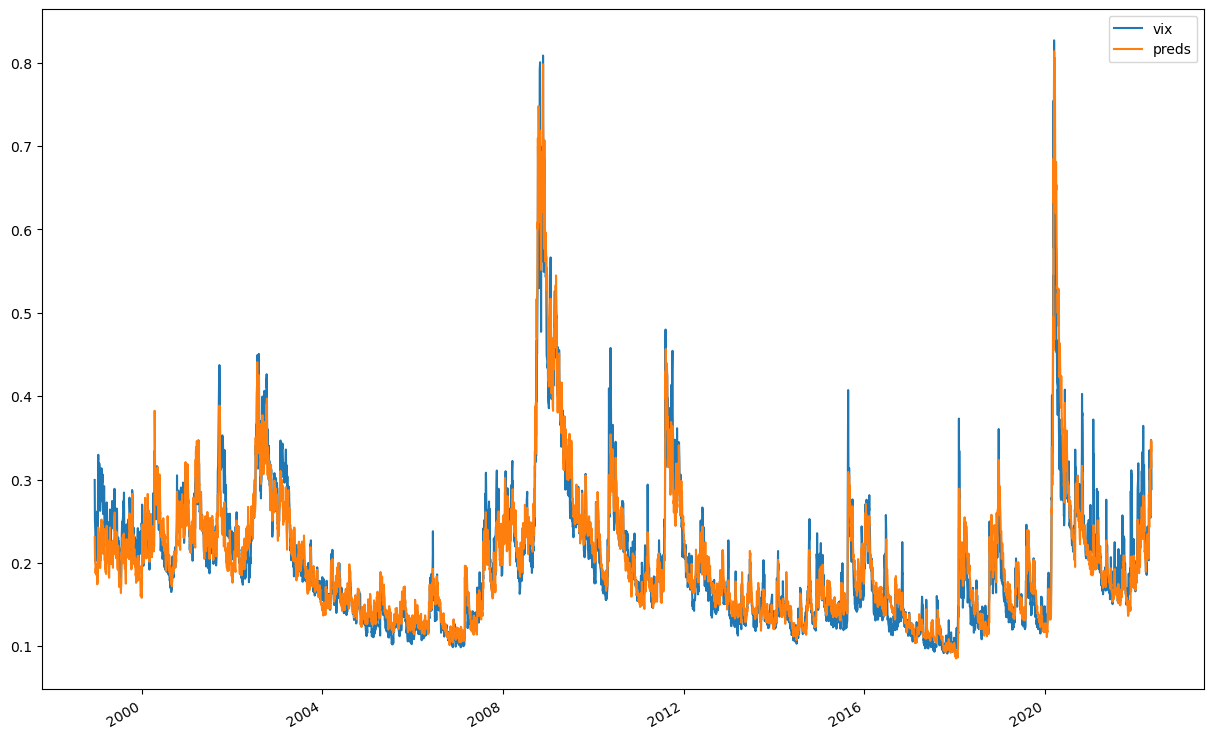

In [ ]:
df_preds[['vix', 'preds']].plot(figsize=(15, 10))